# Build A Basic Chatbot With Langgraph(GRAPH API)

In [35]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [36]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]

In [37]:

import os
from dotenv import load_dotenv
load_dotenv()

True

In [38]:

from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192")

In [39]:

llm=init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000020B3E43AB90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000020B3E3D4650>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [40]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

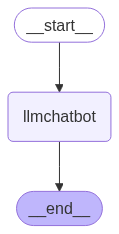

In [41]:
graph_builder=StateGraph(State)

## Adding node
graph_builder.add_node("llmchatbot",chatbot)
## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

## compile the graph
graph=graph_builder.compile()
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [42]:
response=graph.invoke({"messages":"Hi"})
response["messages"][-1].content



"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [43]:
for event in graph.stream({"messages":"Hi How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm just a language model, I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you have! How can I assist you today?


# Chatbot With Tool

In [44]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is LangGraph? - IBM',
   'url': 'https://www.ibm.com/think/topics/langgraph',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeling c

In [45]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b
tools=[tool,multiply]
llm_with_tool=llm.bind_tools(tools)
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000020B3E43AB90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000020B3E3D4650>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

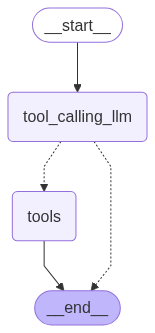

In [46]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [47]:
response=graph.invoke({"messages":"What is the recent ai news"})
response['messages'][-1].content

'{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://analyticsindiamag.com/ai-news-updates/", "title": "Latest AI News, Updates and Launches - Analytics India Magazine", "content": "![AIM](https://analyticsindiamag.com/wp-content/uploads/2021/12/AIM-logo-black.png)\\n\\n# AI News\\n\\nReal-time news coverage on artificial intelligence and tech companies updates and breakthroughs to keep you ahead in the world of AI.\\n\\n## Latest in AI News\\n\\n![Karya AI](https://analyticsindiamag.com/wp-content/uploads/2024/06/9-Voice-Based-Generative-AI-Assistants-1.webp) [...] ![Devika](https://analyticsindiamag.com/wp-content/uploads/2024/08/1723470199735.jpeg)\\n\\n### [YC Startup Unveils Open-Source Graphical Interface for Claude Code](https://analyticsindiamag.com/ai-news-updates/yc-startup-unveils-open-source-graphical-interface-for-claude-code/)\\n\\nBuilt by a startup, Claudia is a free and open-source graphical user interface

In [48]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (y7beg9s7q)
 Call ID: y7beg9s7q
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: day
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://analyticsindiamag.com/ai-news-updates/", "title": "Latest AI News, Updates and Launches - Analytics India Magazine", "content": "![AIM](https://analyticsindiamag.com/wp-content/uploads/2021/12/AIM-logo-black.png)\n\n# AI News\n\nReal-time news coverage on artificial intelligence and tech companies updates and breakthroughs to keep you ahead in the world of AI.\n\n## Latest in AI News\n\n![Karya AI](https://analyticsindiamag.com/wp-content/uploads/

In [49]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (mw3r191pe)
 Call ID: mw3r191pe
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [50]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()


================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (txbhz0ag0)
 Call ID: txbhz0ag0
  Args:
    query: recent ai news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.csoonline.com/article/4008912/wormgpt-returns-new-malicious-ai-variants-built-on-grok-and-mixtral-uncovered.html", "title": "WormGPT returns: New malicious AI variants built on Grok and Mixtral uncovered - csoonline.com", "score": 0.70214266, "published_date": "Wed, 18 Jun 2025 12:17:59 GMT", "content": "news ### New npm threats can erase production systems with a single request Jun 10, 2025 3 mins\n   news ### Chrome ext

# ReAct Agent Architecture

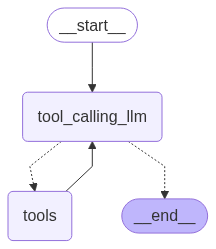

In [51]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [52]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (w1pe1705f)
 Call ID: w1pe1705f
  Args:
    query: recent ai news
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://aibusiness.com/automation/un-warns-of-terrorist-threat-for-self-driving-cars-slaughterbots", "title": "UN Warns of Terrorist Threat for Self-Driving Cars, Slaughterbots - AI Business", "score": 0.67706895, "published_date": "Mon, 23 Jun 2025 16:59:55 GMT", "content": "*   AI Policy #### Recent inResponsible AI Generative AI #### Recent inGenerative AI thumbnailImage 15Generative AI thumbnailImage 20Generative AI Generative AI UK Data Centers Face AI Su